# This notebook illustrates a few tests for the two currently implemented approximations to the Fokker-Planck equation; the Lenard-Bernstein (LB) and Daugherty (DG) implementations. 

# Both are linearized approximations to the non-linear operator. The DG operator, published 5 years after the LB version, improves on the LB version by shifting the moment calculation in each term of the collision operator by the mean velocity. 

# This provides the equation with the ability to conserve momentum and maintain a velocity distribution with non-zero mean velocity. 

# Below, and in the integrated tests in the code, we test each of these phenomena


### Last modified July 3, 2020
### Authored by: Archis Joglekar

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from tests import test_lb, test_dg
from vlapy.core import collisions
from tqdm import tqdm
np.set_printoptions(precision=3, suppress=True)
if test_lb.test_lenard_bernstein_maxwellian_solution() is None:
    print ("Lenard-Bernstein Operator Test -- Maxwellian Solution: Passed")

if test_lb.test_lenard_bernstein_density_conservation() is None:
    print ("Lenard-Bernstein Operator Test -- Density/Charge Conservation: Passed")

if test_lb.test_lenard_bernstein_momentum_conservation_if_initialized_at_zero() is None:
    print ("Lenard-Bernstein Operator Test -- Momentum Conservation: Passed")

if test_lb.test_lenard_bernstein_energy_conservation() is None:
    print ("Lenard-Bernstein Operator Test -- Energy Conservation: Passed")

if test_lb.test_lenard_bernstein_velocity_zero() is None:
    print ("Lenard-Bernstein Operator Test -- Zero Average Velocity as t-> inf: Success")

if test_dg.test_dg_maxwellian_solution() is None:
    print ("Daugherty Operator Test -- Maxwellian Solution: Passed")

if test_dg.test_dg_density_conservation() is None:
    print ("Daugherty Operator Test -- Density/Charge Conservation: Passed")

if test_dg.test_dg_momentum_conservation() is None:
    print ("Daugherty Operator Test -- Momentum Conservation: Passed")

if test_dg.test_dg_energy_conservation() is None:
    print ("Daugherty Operator Test -- Energy Conservation: Passed")



Lenard-Bernstein Operator Test -- Maxwellian Solution: Passed
Lenard-Bernstein Operator Test -- Density/Charge Conservation: Passed
Lenard-Bernstein Operator Test -- Momentum Conservation: Passed
Lenard-Bernstein Operator Test -- Energy Conservation: Passed
Lenard-Bernstein Operator Test -- Zero Average Velocity as t-> inf: Success
Daugherty Operator Test -- Maxwellian Solution: Passed
Daugherty Operator Test -- Density/Charge Conservation: Passed
Daugherty Operator Test -- Momentum Conservation: Passed
Daugherty Operator Test -- Energy Conservation: Passed


# Let's go through these tests step-by-step
## Testing if a Maxwellian Distribution is the steady state solution to this system

Text(0.5, 0.98, 'Testing if the Maxwellian is a steady-state solution of the implementation of the collision operator')

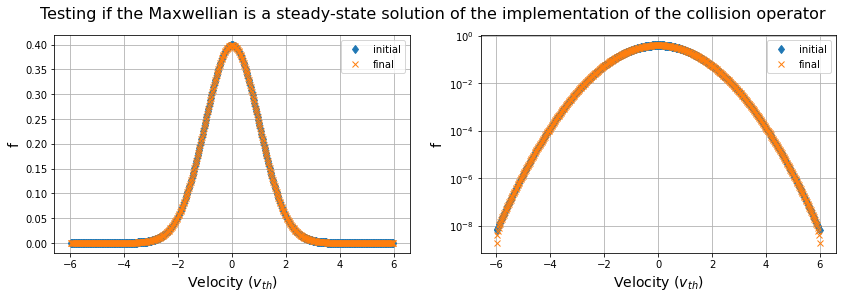

In [2]:
## Set up the grid
vmax = 6.0
nv = 512
dv = 2 * vmax / nv
v = np.linspace(-vmax + dv / 2.0, vmax - dv / 2.0, nv)

# parameters for time evolution
nu = 1e-3
dt = 0.1
v0 = 1.0

# initial distribution function is a Maxwellian
f = np.exp(-(v ** 2.0) / 2.0 / v0) / np.sum(np.exp(-(v ** 2.0) / 2.0 / v0) * dv)
f_out = f.copy()

# iterate for 32 timesteps
for it in range(32):
    f_out = collisions.take_collision_step(collisions.make_philharmonic_matrix, f_out, v, nv, nu, dt, dv)

# test that the initial and final distribution functions are equal
np.testing.assert_almost_equal(f, f_out, decimal=4)


# Visualize
fig = plt.figure(figsize=(14,4))
mxplt = fig.add_subplot(121)
mxplt.plot(v, f, "d", label="initial")
mxplt.plot(v, f_out, "x", label="final")
mxplt.grid()
mxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
mxplt.set_ylabel("f", fontsize=14)
mxplt.legend()

lgmxplt = fig.add_subplot(122)
lgmxplt.semilogy(v, f, "d", label="initial")
lgmxplt.semilogy(v, f_out, "x", label="final")
lgmxplt.grid()
lgmxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
lgmxplt.set_ylabel("f", fontsize=14)
lgmxplt.legend()

fig.suptitle("Testing if the Maxwellian is a steady-state solution of the implementation of the collision operator", fontsize=16)

## Next we test the energy conservation of the implementation of the collision operator for a typical set of collision rate and timescale.

100%|██████████| 9999/9999 [00:46<00:00, 215.76it/s]

Density conservation error = 8.31e-09
Momentum conservation error = -8.33e-16
Energy conservation error = 3.02e-07


Text(0.5, 0.98, 'Testing for density, momentum, and energy conservation')

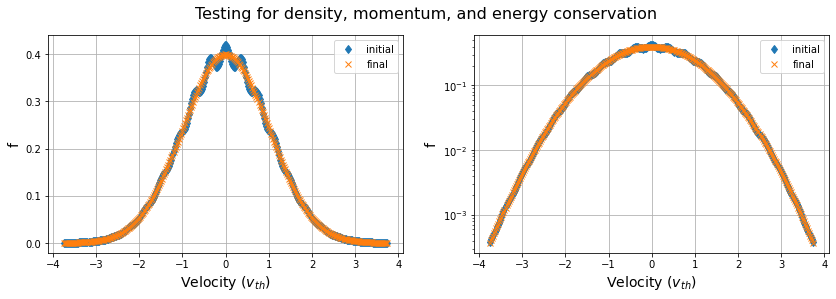

In [3]:
nu = 1e-4
dt = 0.1
v0 = 1.0

f = np.exp(-((v) ** 2.0) / 2.0 / v0)*(1+0.05*np.cos(64*np.pi/12*v))
f = f / np.sum(f * dv)

nt = 10000

f_out = f.copy()

for it in tqdm(range(1,nt)):
    f_out = collisions.take_collision_step(collisions.make_philharmonic_matrix, f_out, v, nv, nu, dt, dv)

temp_in = np.sum(f) * dv
temp_out = np.sum(f_out) * dv
diff = temp_in - temp_out

print ("Density conservation error = " + str(np.format_float_scientific(diff, precision=2)))
np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.sum(f * v) * dv
temp_out = np.sum(f_out * v) * dv
diff = temp_in - temp_out

print ("Momentum conservation error = " + str(np.format_float_scientific(diff, precision=2)))
np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.sum(f * v ** 2.0) * dv
temp_out = np.sum(f_out * v ** 2.0) * dv
diff = temp_in - temp_out

print ("Energy conservation error = " + str(np.format_float_scientific(diff, precision=2)))
np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

pltint = 96

# Visualize
fig = plt.figure(figsize=(14,4))
mxplt = fig.add_subplot(121)
mxplt.plot(v[pltint:-pltint], f[pltint:-pltint], "d", label="initial")
# mxplt.plot(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="middle")
mxplt.plot(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="final")
mxplt.grid()
mxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
mxplt.set_ylabel("f", fontsize=14)
mxplt.legend()

lgmxplt = fig.add_subplot(122)
lgmxplt.semilogy(v[pltint:-pltint], f[pltint:-pltint], "d", label="initial")
lgmxplt.semilogy(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="final")
lgmxplt.grid()
lgmxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
lgmxplt.set_ylabel("f", fontsize=14)
lgmxplt.legend()


fig.suptitle("Testing for density, momentum, and energy conservation", fontsize=16)

## Now we show that the Lenard-Bernstein formulation of the collision operator does not respect energy and momentum conservation when the velocity distribution is not centered at 0. The operator is designed to return the distribution to a mean velocity of 0.

100%|██████████| 9999/9999 [00:45<00:00, 219.59it/s]

Density conservation error = 1.08e-07
Momentum conservation error = 4.76e-02
Energy conservation error = 3.93e-06


Text(0.5, 0.98, 'Testing for density, momentum, and energy conservation for non-zero \nmean velocity distribution with the Lenard-Bernstein operator')

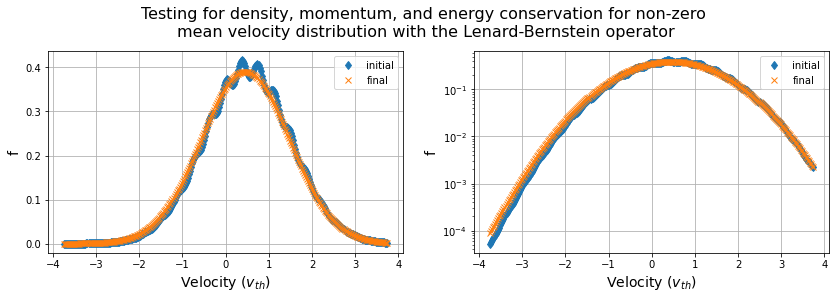

In [4]:
nu = 1e-4
dt = 0.1
v0 = 1.0

f = np.exp(-((v-0.5) ** 2.0) / 2.0 / v0)*(1+0.05*np.cos(64*np.pi/12*v))
f = f / np.sum(f * dv)

nt = 10000

f_out = f.copy()

for it in tqdm(range(1,nt)):
    f_out = collisions.take_collision_step(collisions.make_philharmonic_matrix, f_out, v, nv, nu, dt, dv)

temp_in = np.sum(f) * dv
temp_out = np.sum(f_out) * dv
diff = temp_in - temp_out

print ("Density conservation error = " + str(np.format_float_scientific(diff, precision=2)))
np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.sum(f * v) * dv
temp_out = np.sum(f_out * v) * dv
diff = temp_in - temp_out

print ("Momentum conservation error = " + str(np.format_float_scientific(diff, precision=2)))
# np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.sum(f * v ** 2.0) * dv
temp_out = np.sum(f_out * v ** 2.0) * dv
diff = temp_in - temp_out

print ("Energy conservation error = " + str(np.format_float_scientific(diff, precision=2)))
# np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

pltint = 96

# Visualize
fig = plt.figure(figsize=(14,4))
mxplt = fig.add_subplot(121)
mxplt.plot(v[pltint:-pltint], f[pltint:-pltint], "d", label="initial")
# mxplt.plot(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="middle")
mxplt.plot(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="final")
mxplt.grid()
mxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
mxplt.set_ylabel("f", fontsize=14)
mxplt.legend()

lgmxplt = fig.add_subplot(122)
lgmxplt.semilogy(v[pltint:-pltint], f[pltint:-pltint], "d", label="initial")
lgmxplt.semilogy(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="final")
lgmxplt.grid()
lgmxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
lgmxplt.set_ylabel("f", fontsize=14)
lgmxplt.legend()

fig.subplots_adjust(top=.825)
fig.suptitle("Testing for density, momentum, and energy conservation for non-zero \nmean velocity distribution with the Lenard-Bernstein operator", fontsize=16)

## In contrast, the Daugherty operator does respect density, momentum, and energy conservation for non-zero mean velocity distributions

100%|██████████| 9999/9999 [00:45<00:00, 217.49it/s]


Density conservation error = 7.04e-08
Momentum conservation error = 4.23e-07
Energy conservation error = 2.55e-06


Text(0.5, 0.98, 'Testing for density, momentum, and energy conservation for non-zero \nmean velocity distribution with the Daugherty operator')

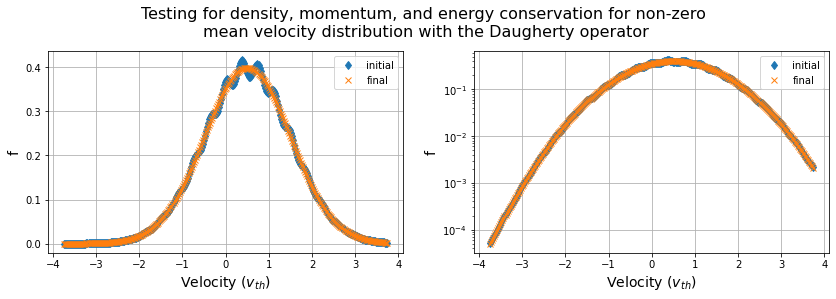

In [5]:
nu = 1e-4
dt = 0.1
v0 = 1.0

f = np.exp(-((v-0.5) ** 2.0) / 2.0 / v0)*(1+0.05*np.cos(64*np.pi/12*v))
f = f / np.sum(f * dv)

nt = 10000

f_out = f.copy()

for it in tqdm(range(1,nt)):
    f_out = collisions.take_collision_step(collisions.make_daugherty_matrix, f_out, v, nv, nu, dt, dv)

temp_in = np.sum(f) * dv
temp_out = np.sum(f_out) * dv
diff = temp_in - temp_out

print ("Density conservation error = " + str(np.format_float_scientific(diff, precision=2)))
np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.sum(f * v) * dv
temp_out = np.sum(f_out * v) * dv
diff = temp_in - temp_out

print ("Momentum conservation error = " + str(np.format_float_scientific(diff, precision=2)))
# np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

temp_in = np.sum(f * v ** 2.0) * dv
temp_out = np.sum(f_out * v ** 2.0) * dv
diff = temp_in - temp_out

print ("Energy conservation error = " + str(np.format_float_scientific(diff, precision=2)))
# np.testing.assert_almost_equal(temp_out, temp_in, decimal=6)

pltint = 96

# Visualize
fig = plt.figure(figsize=(14,4))
mxplt = fig.add_subplot(121)
mxplt.plot(v[pltint:-pltint], f[pltint:-pltint], "d", label="initial")
# mxplt.plot(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="middle")
mxplt.plot(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="final")
mxplt.grid()
mxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
mxplt.set_ylabel("f", fontsize=14)
mxplt.legend()

lgmxplt = fig.add_subplot(122)
lgmxplt.semilogy(v[pltint:-pltint], f[pltint:-pltint], "d", label="initial")
lgmxplt.semilogy(v[pltint:-pltint], f_out[pltint:-pltint], "x", label="final")
lgmxplt.grid()
lgmxplt.set_xlabel("Velocity ($v_{th}$)", fontsize=14)
lgmxplt.set_ylabel("f", fontsize=14)
lgmxplt.legend()

fig.subplots_adjust(top=.825)
fig.suptitle("Testing for density, momentum, and energy conservation for non-zero \nmean velocity distribution with the Daugherty operator", fontsize=16)
